In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pixiedust
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Pixiedust database opened successfully


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('winemag_data_pandata.csv')

# 1. EDA

In [3]:
# data.head()

## Prices for the 3 largest wineries

In [4]:
print(data['winery'].value_counts()[0:3])
# Three largest are Wines & Winemakers, Testarossa, DFJ Vinhos

top3_list = []
wineries = data['winery'].value_counts()[0:3] # Countries with >= 1000 ratings
for winery in wineries.index:
    top3_list.append(winery)
print(top3_list)
data['winery'].value_counts()[0:3].sum()

Wines & Winemakers    222
Testarossa            218
DFJ Vinhos            215
Name: winery, dtype: int64
['Wines & Winemakers', 'Testarossa', 'DFJ Vinhos']


655

In [5]:
print(data.isna().sum())
# Deal with missing data
data = data.dropna(subset=['price'])

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64


In [6]:
top_match = data['winery'].isin(top3_list)
top_data = data[top_match]
top_data = top_data[['points','price', 'winery']]
# top_data.isna().sum()
top_data.head()

,points,price,winery
145,91,64.0,Testarossa
235,85,49.0,Testarossa
525,91,49.0,Testarossa
737,85,12.0,Wines & Winemakers
1177,88,14.0,Wines & Winemakers


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2e7abc88>,
      dtype=object)

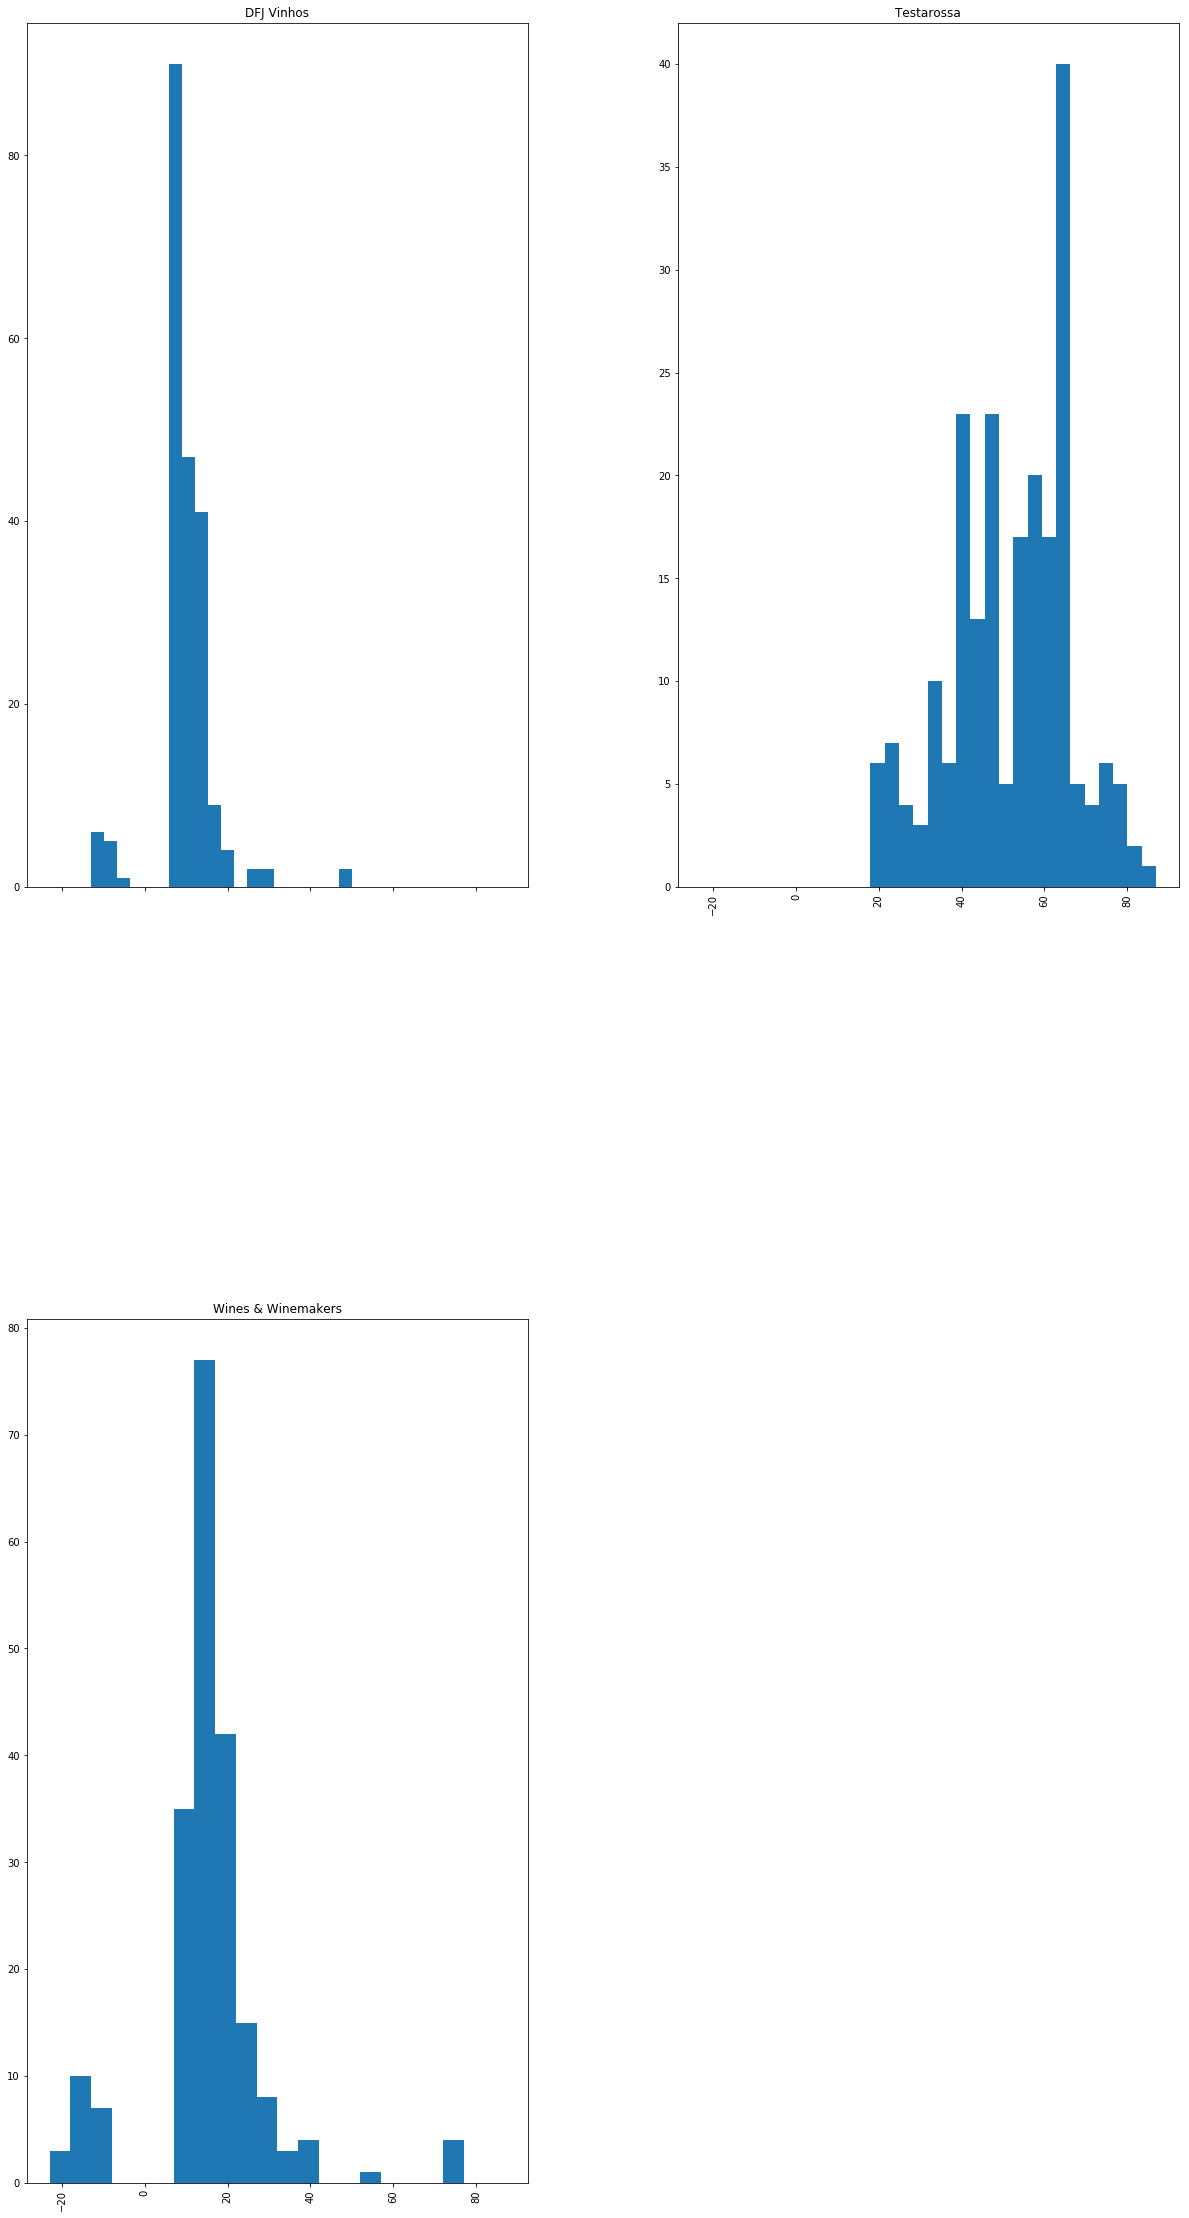

In [36]:
# Originally used pixiedust to create histograms on the fly.
# Refactor with matplotlib here:
top_data['price'].hist(by=top_data['winery'], bins=20, sharex=True, sharey=False, figsize=(20,40))

## Price vs points by country (if >= 1000 reviews)

In [8]:
country_list = []
countries = data['country'].value_counts()[0:12] # Countries with >= 1000 ratings
for country in countries.index:
    country_list.append(country)
print(country_list)
data['country'].value_counts()[0:12].sum()

['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina', 'Austria', 'Australia', 'Germany', 'New Zealand', 'South Africa']


118459

In [9]:
bar_data = data.where(data['country'].isin(country_list))
bar_data = bar_data.dropna(subset=['points','price'])
bar_data = bar_data[['country', 'points', 'price']]
bar_data.count()

country    118459
points     118459
price      118459
dtype: int64

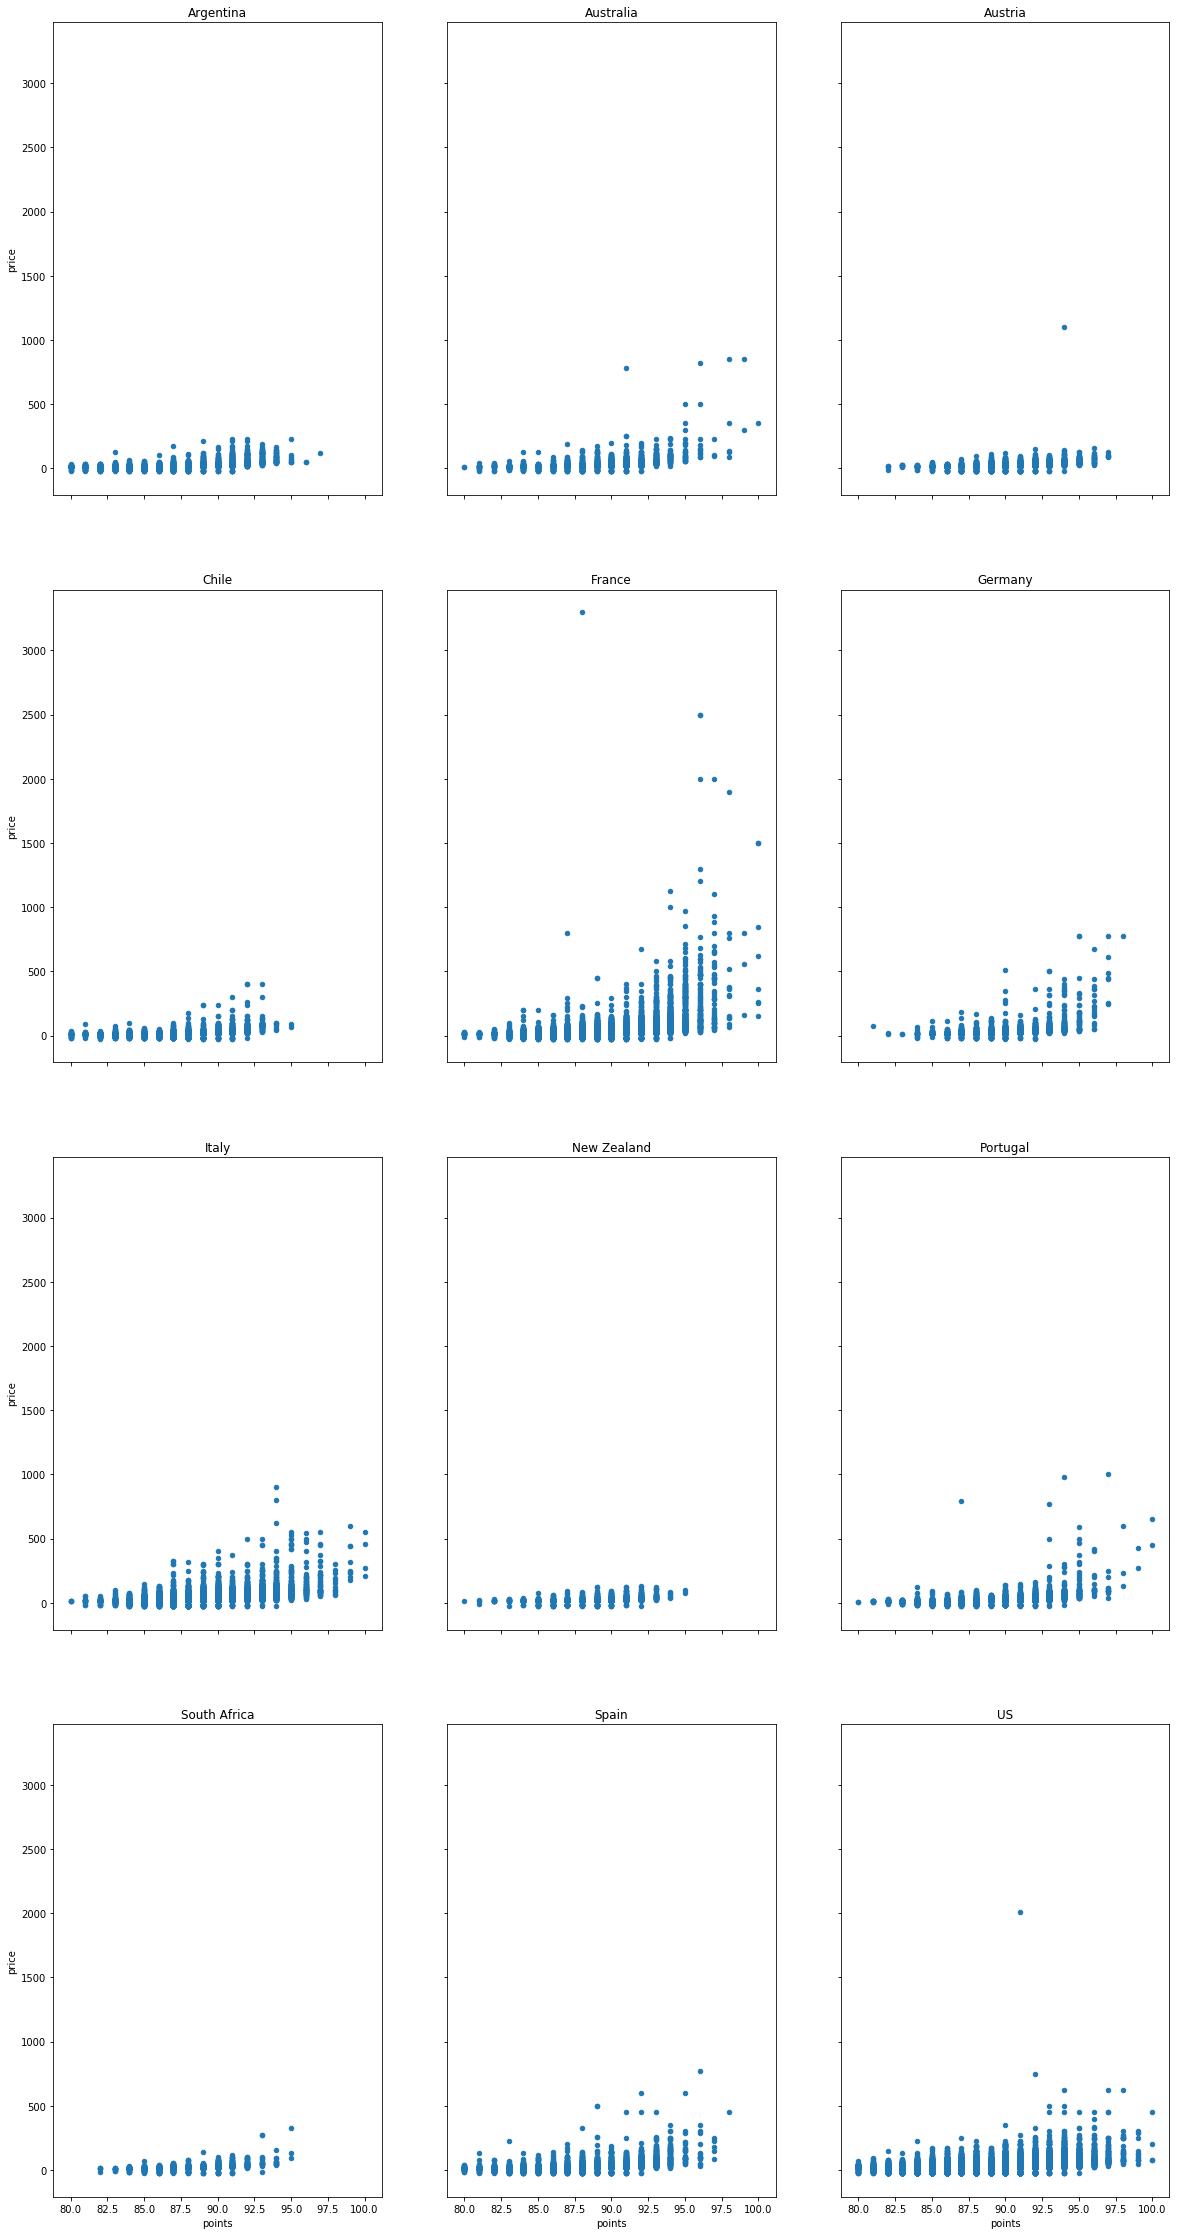

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(20,40))
axes_list = [item for sublist in axes for item in sublist]

for country, values in bar_data.groupby('country'):
    ax = axes_list.pop(0)
    values.plot(x='points', y='price', ax=ax, label=country, legend=False, kind='scatter')
    ax.set_title(country)
    ax.tick_params(
        which='both',
        bottom=True,
        left=True,
        right=False,
        top=False
    )

# 2. Modeling

In [79]:
# Deal with missing data
data = data.dropna(subset=['points'])

In [80]:
# NaNs did not seem to be dropping, but this was because I used .count() instead of .sum()

In [81]:
data.isna().sum()

Unnamed: 0                   0
country                     59
description                  0
designation              34779
points                       0
price                        0
province                    59
region_1                 19575
region_2                 70683
taster_name              24496
taster_twitter_handle    29416
title                        0
variety                      1
winery                       0
dtype: int64

In [83]:
## Linear model - points from price

In [84]:
X = data.loc[:, 'price'].values
X = X[~np.isnan(X)]
y = data.loc[:, 'points'].values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [86]:
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [87]:
y_pred = regressor.predict(X_test.reshape(-1,1))
print(max(y_test - y_pred))

10.240250401315848


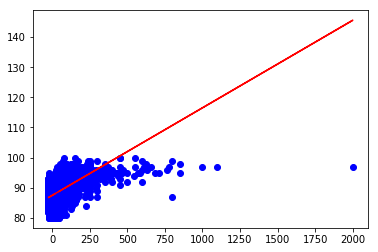

In [88]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.show()

In [89]:
## Linear model - points from log of price

In [90]:
X = data.loc[:, 'price'].values
X = X[~np.isnan(X)]
y = data.loc[:, 'points'].values
print(max(X))

3300.0


In [91]:
X_mean = np.mean(X)

In [92]:
for i in range(len(X)):
    if X[i] > 0:
        X[i] = np.log(X[i]).astype(float)
    else:
        X[i] = np.log(X_mean)
        # Set to a constant while some prices are non-positive
print(max(X))

8.101677747454572


In [93]:
np.count_nonzero(np.isnan(X))

0

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [95]:
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [96]:
y_pred = regressor.predict(X_test.reshape(-1,1))
print(max(y_test - y_pred))

8.688062154251114


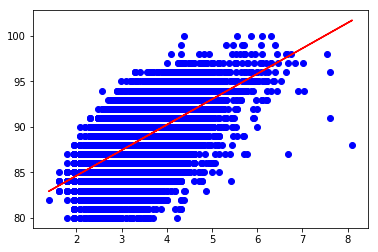

In [97]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.show()

## Note on model preference

In viewing the plots of the above models, we see that the data
in the vanilla linear model tend to fall further from the model
as the price increases, almost seeming to curve.

However, the plot of log(price) versus points fits much more naturally.
This second model still needs some work as the spread is quite wide,
but the shape of the transformed data is a much better fit for a linear model.